In [301]:
#Importing necessary libraries 
import os
import cv2
import shutil
from imageio.v2 import imread
import numpy as np
import pandas as pd 
import tensorflow as tf


import matplotlib.pyplot as plt
plt.style.use('bmh')

from keras import backend as K
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,BatchNormalization

from sklearn.model_selection import train_test_split

import random

In [302]:
#functions that will be needed later
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def create_mlp(dim, regularizer=None):
    """Creates a simple two-layer MLP with inputs of the given dimension"""
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu", kernel_regularizer=regularizer))
    model.add(Dense(4, activation="relu", kernel_regularizer=regularizer))
    return model

def create_cnn(width, height, depth, filters=(16, 32, 64), regularizer=None):
    """
    Creates a CNN with the given input dimension and filter numbers.
    """
    # Initialize the input shape and channel dimension, where the number of channels is the last dimension
    inputShape = (height, width, depth)
    chanDim = -1
 
    # Define the model input
    inputs = Input(shape=inputShape)
 
    # Loop over the number of filters 
    for (i, f) in enumerate(filters):
        # If this is the first CONV layer then set the input appropriately
        if i == 0:
            x = inputs
 
        # Create loops of CONV => RELU => BN => POOL layers
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
    # Final layers - flatten the volume, then Fully-Connected => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16, kernel_regularizer=regularizer)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
 
    # Apply another fully-connected layer, this one to match the number of nodes coming out of the MLP
    x = Dense(4, kernel_regularizer=regularizer)(x)
    x = Activation("relu")(x)
 
    # Construct the CNN
    model = Model(inputs, x)
 
    # Return the CNN
    return model

In [303]:
#(1) Some initilisations
df_training_file = r'../../challenge_files/train.csv'
df_testing_file = r'../../challenge_files/test.csv'
img_col_name_name_in_training_file = 'example_path'
class_col_name_in_training_file = 'label'
training_images_directory = r'../../challenge_files/train_test_data_after_aug/train/'

In [304]:
#(2) Reading and preparing the training dataframe file

df = pd.read_csv(df_training_file)

#Convert the class column into strings
df.loc[:,class_col_name_in_training_file] = df.loc[:,class_col_name_in_training_file].astype(str)

#Keep only the basenames of the files in the example_path column
df.loc[:,img_col_name_name_in_training_file] = df.loc[:,img_col_name_name_in_training_file].apply(lambda x: os.path.basename(x))

df.head()

,label,latitude,longitude,year,example_path
0,0,-2.051853,111.826093,2001,1297.png
1,2,-1.989349,105.309496,2013,1199.png
2,0,1.223256,100.702217,2014,1348.png
3,0,-2.342948,103.890226,2008,2214.png
4,0,-0.126555,101.758175,2011,2220.png


In [305]:
# (3) Print a summary information about the number of training images per class
unique, counts = np.unique(np.array(df.loc[:,class_col_name_in_training_file]),return_counts=True)
percentage = counts/len(df)
counts_df = pd.DataFrame(zip(unique,counts,percentage), columns=['class','count','percentage'])
display(counts_df)

,class,count,percentage
0,0,860,0.501750
1,1,196,0.114352
2,2,658,0.383897


In [306]:
# Some notes:
# -----------
# - It seems that the training dataset is imbalanced. 
# class 1 seems to be the most under-represented
# 
# - We can use augmentation to balance the classes

In [307]:
# (4) Balancing the dataset

balancing_img_gen = ImageDataGenerator(
                rotation_range=10, 
                width_shift_range=0.1, 
                height_shift_range=0.1,
                shear_range=0.15, 
                zoom_range=0.1,
                channel_shift_range = 10, 
                horizontal_flip=True)

# 4.1 generating more images for class 1
augmeted_class1_path = "../../challenge_files/test_aug/class1/"
for im_name in df.loc[df[class_col_name_in_training_file]=='1',img_col_name_name_in_training_file]:
    image_path = os.path.abspath(os.path.join(training_images_directory,str(im_name)))
    image = np.expand_dims(imread(image_path), 0)
    balancing_img_gen.fit(image)
    for x, val in zip(balancing_img_gen.flow(image,                    #image we chose
         save_to_dir=augmeted_class1_path,#this is where we figure out where to save
         save_prefix=f'{im_name}_1_aug', # it will save the images as 'aug_0912' some number for every new augmented image
         save_format='png'),range(random.randint(0,12))) :# here we define a range because we want 10 augmented images otherwise it will keep looping forever I think
        pass

# 4.2 gnerating more images for class 2
augmeted_class2_path = "../../challenge_files/test_aug/class2/"
for im_name in df.loc[df[class_col_name_in_training_file]=='2',img_col_name_name_in_training_file]:
    image_path = os.path.abspath(os.path.join(training_images_directory,str(im_name)))
    image = np.expand_dims(imread(image_path), 0)
    balancing_img_gen.fit(image)
    for x, val in zip(balancing_img_gen.flow(image,                    #image we chose
         save_to_dir=augmeted_class2_path,#this is where we figure out where to save
         save_prefix=f'{im_name}_2_aug', # it will save the images as 'aug_0912' some number for every new augmented image
         save_format='png'),range(random.randint(0,3))) :# here we define a range because we want 10 augmented images otherwise it will keep looping forever I think
        pass
print('image augmentation done ')


# 4.3 add the newly generated images to the testing file and the testing directory
aug_image_names = []
aug_image_classes = []
aug_lon =[]
aug_lat =[]
aug_year=[]

num_required_augmnetations_for_class1= int(counts_df.loc[counts_df['class']=='0','count']) - int(counts_df.loc[counts_df['class']=='1','count'])
num_required_augmnetations_for_class2= int(counts_df.loc[counts_df['class']=='0','count']) - int(counts_df.loc[counts_df['class']=='2','count'])

sample_files_from_class1= random.sample([f'../../challenge_files/test_aug/class1/{file}' for file in os.listdir('../../challenge_files/test_aug/class1/') if file.split('.')[-1]=='png'],num_required_augmnetations_for_class1)
sample_files_from_class2= random.sample([f'../../challenge_files/test_aug/class2/{file}' for file in os.listdir('../../challenge_files/test_aug/class2/') if file.split('.')[-1]=='png'],num_required_augmnetations_for_class2)

augg_files = set(sample_files_from_class1).union(sample_files_from_class2)

for file in augg_files:
    
    aug_im_path = os.path.abspath(file)
    aug_image_name = os.path.basename(aug_im_path)
    dest_path = os.path.abspath(os.path.join(training_images_directory,aug_image_name))
    
    #copy to training file
    shutil.copy(aug_im_path, dest_path)
    #print(f'image {aug_image_name} copied')
    
    original_im_name = aug_image_name.split("_")[0]
    [[label,longitude,latitude , year]] = df.loc[df[img_col_name_name_in_training_file]==original_im_name,[class_col_name_in_training_file,'longitude','latitude','year']].values
    
    aug_image_names.append(aug_image_name)
    aug_image_classes.append(label)
    aug_lon.append(latitude)
    aug_lat.append(longitude)
    aug_year.append(year)

# 4.4 update trainig dataframe 
aug_df = pd.DataFrame(zip(aug_image_classes,aug_image_names,aug_lon,aug_lat,aug_year),columns=[class_col_name_in_training_file,img_col_name_name_in_training_file,'longitude','latitude','year'])

df_ = pd.concat([df,aug_df])
unique, counts = np.unique(np.array(df_.loc[:,class_col_name_in_training_file]),return_counts=True)
percentage = counts/len(df_)
counts_df = pd.DataFrame(zip(unique,counts,percentage), columns=['class','count','percentage'])
display(counts_df)

image augmentation done 


,class,count,percentage
0,0,860,0.333333
1,1,860,0.333333
2,2,860,0.333333


In [311]:
# (5) Split data into train-test data sets

X = df_.loc[:,img_col_name_name_in_training_file]
y = df_.loc[:,class_col_name_in_training_file]

# Split
train_x, val_x, train_y, val_y = train_test_split(X, y, 
                                              test_size = 0.1, 
                                              random_state = 27, 
                                              stratify=y)

# Train df
df_train = pd.DataFrame(columns=['image_name','category'])
df_train['image_name'] = train_x
df_train['category'] = train_y

# Test df
df_test= pd.DataFrame(columns=['image_name','category'])
df_test['image_name'] = val_x
df_test['category'] = val_y

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

#display(df_train.head())
#display(df_test.head())

print(df.shape)
print(df_train.shape)
print(df_test.shape)

(1714, 5)
(2322, 2)
(258, 2)


In [312]:
# (6) Append images into a list and prepare them to be input to the model.

# Images
train_images = df_train.loc[:,'image_name']
train_labels = df_train.loc[:,'category']

test_images = df_test.loc[:,'image_name']
test_labels = df_test.loc[:,'category']

# Train images
x_train = []
for i in train_images:
    image_path = os.path.abspath(os.path.join(training_images_directory,str(i)))
    img = cv2.imread(image_path)
    x_train.append(img)

# Train labels
y_train= to_categorical(train_labels)

# Test images
x_test = []
for i in test_images:
    image_path = os.path.abspath(os.path.join(training_images_directory,str(i)))
    img = cv2.imread(image_path)
    x_test.append(img)

# Test labels
y_test=to_categorical(test_labels)

# Normalize images
x_train = np.array(x_train, dtype="float") / 255.0
x_test = np.array(x_test, dtype="float") / 255.0



In [313]:
img.shape

(332, 332, 3)

In [314]:
# (7) Building the model
#Let’s create the architecture for our CNN model. 
# Three Convolutional layers and two fully connected layers.

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(332, 332, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.24))
model.add(Dense(3,activation='softmax'))


# Compile
optim = RMSprop(learning_rate=0.00001)
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['acc',f1_m,precision_m, recall_m])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 330, 330, 32)      896       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 165, 165, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 163, 163, 32)      9248      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 81, 81, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 79, 79, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 39, 39, 64)      

In [316]:
# (8) Train first without augmnetaiton to check
epochs = 50
batch_size =32
# Fit
history = model.fit(x_train,y_train,
                    epochs=epochs,
                    validation_data=(x_test,y_test),
                    batch_size=batch_size,
                    verbose=1)

Epoch 1/50
73/73 [==============================] - 93s 1s/step - loss: 0.9439 - acc: 0.5728 - f1_m: 0.2702 - precision_m: 0.8044 - recall_m: 0.1648 - val_loss: 0.8906 - val_acc: 0.5736 - val_f1_m: 0.3145 - val_precision_m: 0.7357 - val_recall_m: 0.2049
Epoch 2/50
73/73 [==============================] - 86s 1s/step - loss: 0.9122 - acc: 0.5792 - f1_m: 0.2956 - precision_m: 0.8012 - recall_m: 0.1861 - val_loss: 0.8691 - val_acc: 0.6163 - val_f1_m: 0.3133 - val_precision_m: 0.7293 - val_recall_m: 0.2049
Epoch 3/50
73/73 [==============================] - 84s 1s/step - loss: 0.8878 - acc: 0.5788 - f1_m: 0.3325 - precision_m: 0.8031 - recall_m: 0.2144 - val_loss: 0.8385 - val_acc: 0.5775 - val_f1_m: 0.3695 - val_precision_m: 0.7505 - val_recall_m: 0.2500
Epoch 4/50
73/73 [==============================] - 86s 1s/step - loss: 0.8812 - acc: 0.5788 - f1_m: 0.3595 - precision_m: 0.7894 - recall_m: 0.2361 - val_loss: 0.8683 - val_acc: 0.5698 - val_f1_m: 0.3209 - val_precision_m: 0.7057 - val_r

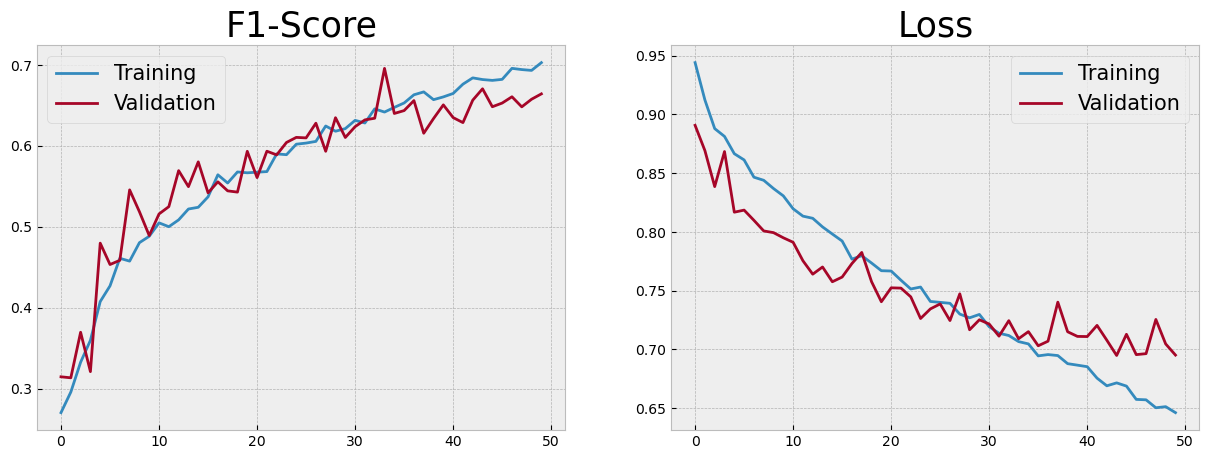

In [317]:
#plot f1-score
training_f1_score = history.history['f1_m']
validation_f1_score = history.history['val_f1_m']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

fig, axis = plt.subplots(1,2,figsize=(15, 5))

axis[0].plot(epochs_range,training_f1_score, label= 'Training')
axis[0].plot(epochs_range,validation_f1_score, label= 'Validation')
axis[0].legend(fontsize=15)
axis[0].set_title('F1-Score', fontsize=25)

axis[1].plot(epochs_range,loss, label= 'Training')
axis[1].plot(epochs_range,val_loss, label= 'Validation')
axis[1].legend(fontsize=15)
axis[1].set_title('Loss', fontsize=25)


fig.savefig('results_after_balancing.png')

In [328]:
#predict
df_for_predictions = pd.read_csv("../../challenge_files/test.csv")
df_for_predictions.loc[:,"example_path"] = df.loc[:,"example_path"].apply(lambda x: os.path.basename(x))

testing_images_directory = r'../../challenge_files/train_test_data_after_aug/train/'
x_for_predictions = []
for i in df_for_predictions.loc[:,'example_path']:
    image_path = os.path.abspath(os.path.join(testing_images_directory,str(i)))
    img = cv2.imread(image_path)
    x_for_predictions.append(img)

x_for_predictions = np.reshape(x_for_predictions,[len(x_for_predictions),332,332,3])
classes = model.predict(x_for_predictions)

(635, 332, 332, 3)

In [353]:
df_predict = pd.DataFrame(zip(df_for_predictions.index,[i.numpy() for i in K.argmax(classes)]))
df_predict.loc[:,df_predict.columns[0]]=df_predict.loc[:,df_predict.columns[0]]+1
df_predict = df_predict.set_index(df_predict.columns[0])
df_predict.columns = ['target']
df_predict.to_json('predicti')

[1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
